In [1]:
import torch
from torch import nn
from sklearn.datasets import make_moons
from sklearn.datasets import make_gaussian_quantiles
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [2]:
from neural_ode import NeuralODENetwork
from solvers.euler import EulerSolver

In [18]:
NUM_CLASSES = 2

In [19]:
def generate_tight_spirals(n_points, noise=0.05, n_classes=3, revolutions=3):
    X = []
    y = []
    
    # Generate points for each class
    for i in range(n_classes):
        ix = np.linspace(0, 1, n_points // n_classes)  # Points along the spiral
        r = ix * 5                                     # Spiral radius
        theta = ix * revolutions * 2 * np.pi + i * (2 * np.pi / n_classes)  # Spiral angle with offset per class
        
        x1 = r * np.sin(theta) + np.random.normal(0, noise, ix.shape)
        x2 = r * np.cos(theta) + np.random.normal(0, noise, ix.shape)
        X.extend(np.c_[x1, x2])
        y.extend([i] * len(ix))  # Assign class label

    return np.array(X), np.array(y)

# Generate tight interlocking spirals
X, y = generate_tight_spirals(n_points=2000, noise=0.2, n_classes=NUM_CLASSES, revolutions=2)

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

y_train = torch.nn.functional.one_hot(y_train, num_classes=NUM_CLASSES)
y_test = torch.nn.functional.one_hot(y_test, num_classes=NUM_CLASSES)

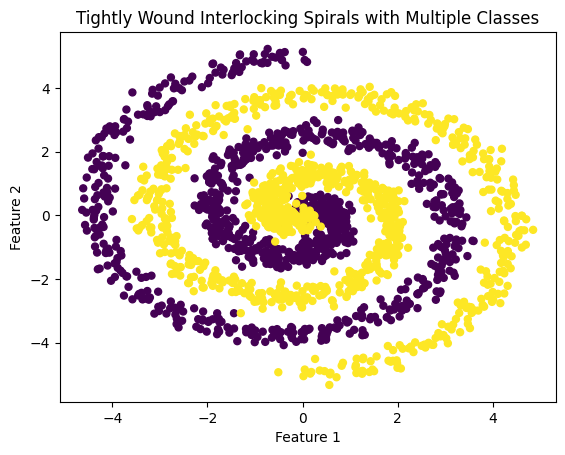

In [20]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=25)
plt.title("Tightly Wound Interlocking Spirals with Multiple Classes")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [21]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor = torch.tensor(y_test, dtype=torch.float32)

/tmp/ipykernel_42296/2998404806.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
/tmp/ipykernel_42296/2998404806.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_tensor = torch.tensor(X_test, dtype=torch.float32)
/tmp/ipykernel_42296/2998404806.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
/tmp/ipykernel_42296/2998404806.py:4: UserWarning: To copy construct from a tensor, it is recommended to use source

In [22]:
def train_model(model, epochs):
    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    train_losses = []
    val_losses = []
    accuracies = []
    
    for epoch in range(epochs):
        n_ode.train()  # Set the model to training mode
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(X_train_tensor)  # Forward pass
        loss = criterion(outputs, y_train_tensor)  # Compute the loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update the weights       
        train_losses.append(loss.item())
        n_ode.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # No gradients needed for validation
            val_outputs = model(X_val_tensor)
            _, predicted = torch.max(val_outputs, 1)  # Get predicted class labels
            _, validation_tensor = torch.max(y_val_tensor, 1)
            val_loss = criterion(val_outputs, y_val_tensor)
            val_losses.append(val_loss.item())
            val_accuracy = (predicted == validation_tensor).sum().item() / y_val_tensor.size(0)
            accuracies.append(val_accuracy)
            if (epoch + 1) % 50 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
                print(f"Validation Loss: {val_loss.item():.4f}, Validation Accuracy: {val_accuracy:.4f}")

    return train_losses, val_losses, accuracies

In [23]:
INPUT_DIM = 25

latent_converter = nn.Sequential(
                    nn.Linear(2, INPUT_DIM),
                    nn.ReLU()
                   )

dynamics_approximator = nn.Sequential(
                  nn.Linear(INPUT_DIM + 1, INPUT_DIM//2),
                  nn.ReLU(),
                  nn.Linear(INPUT_DIM//2, INPUT_DIM//4),
                  nn.ReLU(),
                  nn.Linear(INPUT_DIM//4, INPUT_DIM//2),
                  nn.ReLU(),
                  nn.Linear(INPUT_DIM//2, INPUT_DIM),               
                )

classifier_head = nn.Sequential(
                  nn.Linear(INPUT_DIM, NUM_CLASSES),                
                )

solver = EulerSolver(timesteps_number=15, time_range=(0, 1))
n_ode = NeuralODENetwork(latent_dynamics_function=dynamics_approximator, solver=solver)

n_ode.attach_pre_solver_function(latent_converter)
n_ode.attach_task_head(classifier_head)

In [24]:
train_loss_node, val_loss_node, acc_node = train_model(n_ode, epochs=1500)

Epoch [50/1500], Loss: 0.6626
Validation Loss: 0.6715, Validation Accuracy: 0.6033
Epoch [100/1500], Loss: 0.6242
Validation Loss: 0.6394, Validation Accuracy: 0.5867
Epoch [150/1500], Loss: 0.5174
Validation Loss: 0.5403, Validation Accuracy: 0.6583
Epoch [200/1500], Loss: 0.2690
Validation Loss: 0.2835, Validation Accuracy: 0.9483
Epoch [250/1500], Loss: 0.0829
Validation Loss: 0.0833, Validation Accuracy: 0.9733
Epoch [300/1500], Loss: 0.0544
Validation Loss: 0.0689, Validation Accuracy: 0.9767
Epoch [350/1500], Loss: 0.0479
Validation Loss: 0.0681, Validation Accuracy: 0.9783
Epoch [400/1500], Loss: 0.0440
Validation Loss: 0.0692, Validation Accuracy: 0.9817
Epoch [450/1500], Loss: 0.0412
Validation Loss: 0.0742, Validation Accuracy: 0.9833
Epoch [500/1500], Loss: 0.0389
Validation Loss: 0.0810, Validation Accuracy: 0.9817
Epoch [550/1500], Loss: 0.0375
Validation Loss: 0.0881, Validation Accuracy: 0.9817
Epoch [600/1500], Loss: 0.2582
Validation Loss: 0.0938, Validation Accuracy: 

In [25]:
class TestMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
                        nn.Linear(2, INPUT_DIM),
                        nn.ReLU(),
                      nn.Linear(INPUT_DIM, INPUT_DIM//2),
                      nn.ReLU(),
                      nn.Linear(INPUT_DIM//2, INPUT_DIM//4),
                      nn.ReLU(),
                      nn.Linear(INPUT_DIM//4, INPUT_DIM//2),
                      nn.ReLU(),
                      nn.Linear(INPUT_DIM//2, INPUT_DIM),               
                      nn.Linear(INPUT_DIM, NUM_CLASSES),                
                        )
    def forward(self, x):
        return self.net(x)

mlp = TestMLP()

In [26]:
train_loss_mlp, val_loss_mlp, acc_mlp = train_model(mlp, epochs=1500)

Epoch [50/1500], Loss: 0.6738
Validation Loss: 0.6814, Validation Accuracy: 0.5900
Epoch [100/1500], Loss: 0.6641
Validation Loss: 0.6766, Validation Accuracy: 0.5883
Epoch [150/1500], Loss: 0.6567
Validation Loss: 0.6686, Validation Accuracy: 0.6167
Epoch [200/1500], Loss: 0.6301
Validation Loss: 0.6434, Validation Accuracy: 0.6583
Epoch [250/1500], Loss: 0.3455
Validation Loss: 0.3671, Validation Accuracy: 0.8950
Epoch [300/1500], Loss: 0.0979
Validation Loss: 0.0932, Validation Accuracy: 0.9867
Epoch [350/1500], Loss: 0.0605
Validation Loss: 0.0529, Validation Accuracy: 0.9900
Epoch [400/1500], Loss: 0.0510
Validation Loss: 0.0415, Validation Accuracy: 0.9850
Epoch [450/1500], Loss: 0.0471
Validation Loss: 0.0366, Validation Accuracy: 0.9867
Epoch [500/1500], Loss: 0.0447
Validation Loss: 0.0338, Validation Accuracy: 0.9883
Epoch [550/1500], Loss: 0.0429
Validation Loss: 0.0341, Validation Accuracy: 0.9867
Epoch [600/1500], Loss: 0.0416
Validation Loss: 0.0362, Validation Accuracy: 

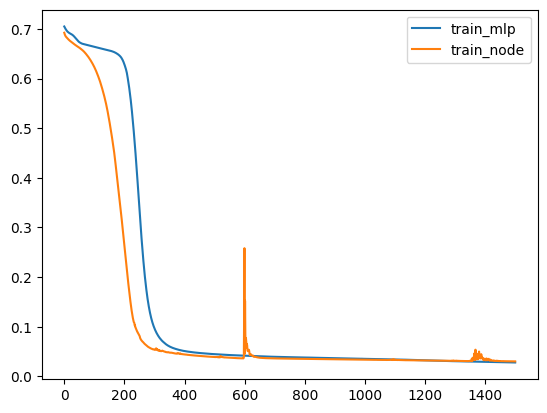

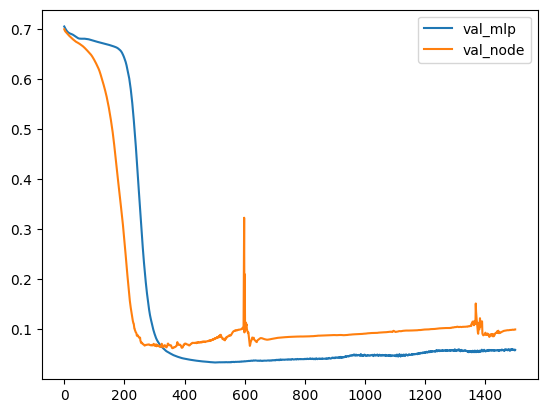

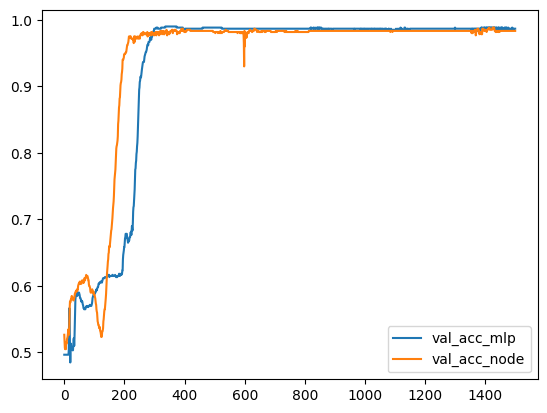

In [27]:
plt.plot(train_loss_mlp, label="train_mlp")
plt.plot(train_loss_node, label="train_node")
plt.legend()
plt.show()

plt.plot(val_loss_mlp, label="val_mlp")
plt.plot(val_loss_node, label="val_node")
plt.legend()
plt.show()

plt.plot(acc_mlp, label="val_acc_mlp")
plt.plot(acc_node, label="val_acc_node")
plt.legend()
plt.show()